# Ignore this

In [ ]:
import pandas as pd


class Preprocess():
    def __init__(self):
        sea_ice_data = pd.read_csv('N_seaice_extent_daily_v3.0.csv')
        sea_ice_data = sea_ice_data.drop(index = 0, axis = 0)
        sea_ice_data = sea_ice_data.rename(columns = lambda x: x.strip())
        sea_ice_data = sea_ice_data.drop(columns = ['Month', 'Day', 'Missing', 'Source Data'], axis = 1)
        sea_ice_data = self.sea_ice_averages(sea_ice_data)

        co2_data = pd.read_csv('co2_mm_mlo.csv')
        co2_data = co2_data.rename(columns = lambda x: x.strip())
        co2_data = co2_data.drop(columns = ['month', 'decimal date', 'de-seasonalized', '#days', 'st.dev of days', 'unc. of mon mean'], axis = 1)
        co2_data = self.co2_averages(co2_data)
        co2_data = co2_data.loc[co2_data['year'] > 1977]
        co2_data = co2_data.reset_index()

        celsius_data = pd.read_csv('graph.csv')
        celsius_data = celsius_data.rename(columns = lambda x: x.strip())
        celsius_data = celsius_data.drop(columns = ['Lowess(5)'], axis = 1)
        celsius_data = celsius_data.loc[celsius_data['Year'] > 1977]
        celsius_data = celsius_data.append(pd.DataFrame({'Year': [2022],
                                          'No_Smoothing': [0.84] #interpolated as 2021 value, assuming the data follows a trend
                                         }))
        celsius_data = celsius_data.reset_index()                             

        all_data = sea_ice_data
        all_data['Global CO2'] = co2_data['monthly average']
        all_data['Temp Diff From Average'] = celsius_data['No_Smoothing']
        sea_ice_data.to_csv('sea_avg_multi.csv', index=False) #SEA ICE DATA TO A CSV
        
        #min max normalisation
        all_data['Extent'] = (all_data['Extent'] - all_data['Extent'].min()) / (all_data['Extent'].max() - all_data['Extent'].min()) 
        all_data['Global CO2'] = (all_data['Global CO2'] - all_data['Global CO2'].min()) / (all_data['Global CO2'].max() - all_data['Global CO2'].min())
        all_data['Temp Diff From Average'] = (all_data['Temp Diff From Average'] - all_data['Temp Diff From Average'].min()) / (all_data['Temp Diff From Average'].max() - all_data['Temp Diff From Average'].min()) 
        
        print(sea_ice_data.head())
        print(all_data.head())
    
    def sea_ice_averages(self, sea_ice_data):
        sea_ice_data['Year'] = pd.to_numeric(sea_ice_data['Year'])
        sea_ice_data['Extent'] = pd.to_numeric(sea_ice_data['Extent'])
        
        unique_vals = pd.unique(sea_ice_data['Year'])

        yearly_averages = []
        for i in unique_vals:
            x = 0
            y = 0
            for index, row in sea_ice_data.iterrows():
                if row['Year'] == i:
                    x += row['Extent']
                    y += 1
                    sea_ice_data = sea_ice_data.drop(index, axis = 0)
                else:
                    break
            yearly_averages.append(x / y)

        sea_ice_data['Year'] = unique_vals
        sea_ice_data['Extent'] = yearly_averages
        sea_ice_data.to_csv('sea_avg.csv', index=False) #SEA ICE DATA TO A CSV
        return sea_ice_data

    def co2_averages(self, co2_data):
        co2_data['year'] = pd.to_numeric(co2_data['year'])
        co2_data['monthly average'] = pd.to_numeric(co2_data['monthly average'])
        
        unique_vals = pd.unique(co2_data['year'])

        yearly_averages = []
        for i in unique_vals:
            x = 0
            y = 0
            for index, row in co2_data.iterrows():
                if row['year'] == i:
                    x += row['monthly average']
                    y += 1
                    co2_data = co2_data.drop(index, axis = 0)
                else:
                    break
            yearly_averages.append(x / y)

        co2_data['year'] = unique_vals
        co2_data['monthly average'] = yearly_averages
        return co2_data

def main():
    df = Preprocess()
if __name__ == '__main__':
    main()

# Start reading code from here

In [356]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [357]:
df = pd.read_csv('sea_avg_multi.csv')
df.head()

df = df.sample(frac=1, random_state=20).reset_index(drop=True) #shuffle dataframe
df.head()

#Splitting in train and test
split = math.floor(df.shape[0]*0.2) #80-20% split
test = df.head(n=split)
train = df.drop(index=df.index[:split]).reset_index(drop=True)
print(train.shape)
print(test.shape)

(36, 4)
(9, 4)


In [358]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_test = test['Extent'].to_numpy()

X_train = train.drop(['Extent'],axis=1)
X_test = test.drop(['Extent'],axis=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train = (X_train-mu)/sigma
print(X_train.head())
print(type(X_train))

#Adding column of 1 in X to multiply with theta0
X_zero = np.ones((X_train.shape[0],1))
X_train = np.hstack((X_zero,X_train))
print(X_train.shape)
print(type(X_train))

(36, 3) (9, 3) (36,) (9,)
(3,) (3,)
       Year  Global CO2  Temp Diff From Average
0 -0.762153   -0.794758               -1.316136
1 -0.514969   -0.603035               -0.408930
2  0.061796   -0.061825                0.333329
3  1.544906    1.706310                1.982794
4 -1.668498   -1.506846               -0.903769
<class 'pandas.core.frame.DataFrame'>
(36, 4)
<class 'numpy.ndarray'>


In [359]:
class multiLinearRegression:
    def __init__(self):
        print("Regressor created")
        
    def predict(self, X,theta):
        return np.dot(X,theta)

    def error(self, X,y,theta):
        m = X.shape[0]
        e = 0.0
        y_hat = self.predict(X,theta)
        e = (np.sum((y-y_hat)**2))/m
        
        return e

    def r2_score(self, X,y):
        y_hat = self.predict(X,theta)
        num = np.sum((y-y_hat)**2)
        denom = np.sum((y-y.mean())**2)
        score = (1-num/denom)
        
        return score*100

    def gradient(self, X,y,theta):
        m = X.shape[0]
        y_hat = self.predict(X,theta)
        grad = (np.dot(X.T,(y_hat-y)))/m
        
        return grad

    def fit(self, X,y,learning_rate=0.05,max_epochs=100):
        n = X.shape[1]
        theta = np.zeros((n,))
        error_list = []

        for i in range(max_epochs):
            e = self.error(X,y,theta)
            error_list.append(e)

            grad = self.gradient(X,y,theta)
            theta = theta - learning_rate*grad

        return theta,error_list

    def test_preprocess(self, X):
        X = (X-mu)/sigma
        X_zero = np.ones((X.shape[0],1))
        X = np.hstack((X_zero,X))
        
        return X

In [360]:
learning_rate = 0.1
epochs = 500
model = multiLinearRegression()
theta, error_list = model.fit(X_train,y_train,learning_rate,epochs)

Regressor created


In [361]:
print("Value of weights are: ",theta)

Value of weights are:  [11.29327245 -0.20826991 -0.17998155 -0.24349033]


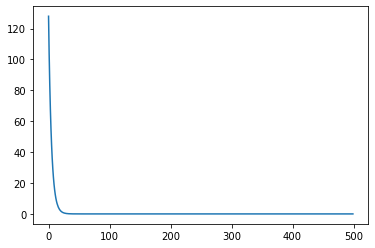

In [362]:
#Plotting error
plt.plot(error_list)
plt.show()

In [363]:
#Evaluation on test set
X_test = model.test_preprocess(X_test)
print("MSE on test set is: ",model.error(X_test,y_test,theta))
print("R^2 score on test is: ",model.r2_score(X_test,y_test))

MSE on test set is:  0.028605078869859486
R^2 score on test is:  95.9213030863581


### Predict ice extent for any given set of features by passing it through test process and calling the method predict

# Code for predicting the year when ice extent is going to hit zero

In [364]:
df = pd.read_csv('sea_avg.csv')
df.head()

df = df.sample(frac=1, random_state=10).reset_index(drop=True) #shuffle dataframe
df.head()

#Splitting in train and test
split = math.floor(df.shape[0]*0.2) #80-20% split
test = df.head(n=split)
train = df.drop(index=df.index[:split]).reset_index(drop=True)
print(train.shape)
print(test.shape)

(36, 2)
(9, 2)


In [365]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_test = test['Extent'].to_numpy()

X_train = train.drop(['Extent'],axis=1)
X_ = X_train.copy()
X_test = test.drop(['Extent'],axis=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train = (X_train-mu)/sigma
print(X_train.head())
print(type(X_train))

#Adding column of 1 in X to multiply with theta0
X_zero = np.ones((X_train.shape[0],1))
X_train = np.hstack((X_zero,X_train))
print(X_train.shape)
print(type(X_train))

(36, 1) (9, 1) (36,) (9,)
(1,) (1,)
       Year
0 -1.097376
1 -1.172339
2 -1.472192
3  1.151516
4  1.301442
<class 'pandas.core.frame.DataFrame'>
(36, 2)
<class 'numpy.ndarray'>


In [366]:
class linearRegression:
    def __init__(self):
        print("Regressor created")
        
    def predict(self, X,theta):
        return np.dot(X,theta)

    def error(self, X,y,theta):
        m = X.shape[0]
        e = 0.0
        y_hat = self.predict(X,theta)
        e = (np.sum((y-y_hat)**2))/m
        
        return e

    def r2_score(self, X,y):
        y_hat = self.predict(X,theta)
        num = np.sum((y-y_hat)**2)
        denom = np.sum((y-y.mean())**2)
        score = (1-num/denom)
        
        return score*100

    def gradient(self, X,y,theta):
        m = X.shape[0]
        y_hat = self.predict(X,theta)
        grad = (np.dot(X.T,(y_hat-y)))/m
        
        return grad

    def fit(self, X,y,learning_rate=0.05,max_epochs=100):
        n = X.shape[1]
        theta = np.zeros((n,))
        error_list = []

        for i in range(max_epochs):
            e = self.error(X,y,theta)
            error_list.append(e)

            grad = self.gradient(X,y,theta)
            theta = theta - learning_rate*grad

        return theta,error_list

    def test_preprocess(self, X):
        X = (X-mu)/sigma
        X_zero = np.ones((X.shape[0],1))
        X = np.hstack((X_zero,X))
        
        return X

In [367]:
learning_rate = 0.1
epochs = 200
model = linearRegression()
theta, error_list = model.fit(X_train,y_train,learning_rate,epochs)

Regressor created


In [368]:
print("Learned weights are: ",theta)

Learned weights are:  [11.36949157 -0.67294819]


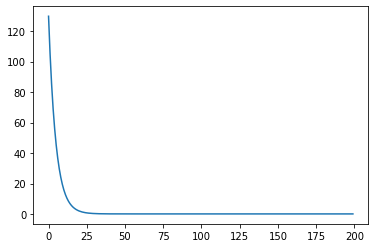

In [369]:
#Plotting error
plt.plot(error_list)
plt.show()

In [370]:
#Evaluation on test set
X_test = model.test_preprocess(X_test)
print("MSE on test set is: ",model.error(X_test,y_test,theta))
print("R^2 score on test is: ",model.r2_score(X_test,y_test))

MSE on test set is:  0.059613523257420385
R^2 score on test is:  87.75343194983189


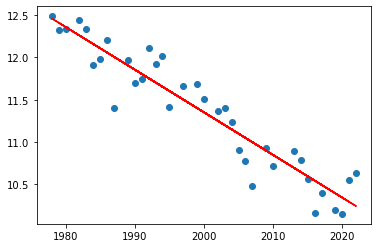

In [371]:
#plotting fitted line
y_hat = predict(X_train,theta)
plt.scatter(X_['Year'],y_train)
plt.plot(X_['Year'],y_hat, color='red')
plt.show()

In [372]:
#Takes numpy array as input instead of dataframe like in the method built in class
def prediction(X_test):
    df_test = pd.DataFrame(X_test, columns=['Year'])
    df_test = (df_test-mu)/sigma
    X_zero = np.ones((df_test.shape[0],1))
    X_test = np.hstack((X_zero,df_test))
    y_pred = predict(X_test,theta)
    return y_pred

Year when ice extent hits 0 is:  2225


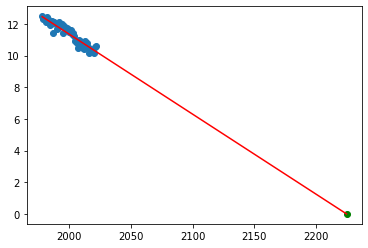

In [373]:
#Predicting in which year ice extent would hit zero

y_pred = []
year = []
yr = 1978
while(True):
    y_hat = prediction(np.array([yr]))
    if(y_hat<0):
        break
    year.append(yr)
    y_pred.append(y_hat)
    yr = yr+1
    
print("Year when ice extent hits 0 is: ",year[-1])
plt.scatter(df['Year'],df['Extent'])
plt.plot(year,y_pred, color='red')
#plt.plot(df[:,1],y_hat,c="red")
plt.scatter(year[-1],y_pred[-1],color='green')
plt.show()